<a href="https://colab.research.google.com/github/reckoning-machines/sec_test/blob/master/sec_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#i've had best success with Runtime / Change Runtime Type / Hardware Accelerator = None

# why use R here?  
# edgarWebR pulls sections really well
!rm -r 'sec_test'
!rm -r 'Archives'
!git clone https://github.com/reckoning-machines/sec_test.git #errors if exists but doesn't halt exe
!cp "sec_test/test_ticker_list.csv" "test_ticker_list.csv" #move ticker list to root


rm: cannot remove 'Archives': No such file or directory
Cloning into 'sec_test'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 37 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [23]:
# activate R magic
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [24]:
%%R
#installs take a bit of time...
print('Startup: install packages... (may take a few minutes the first time)')

library(devtools)

devtools::install_github("mwaldstein/edgarWebR",quietly=TRUE)
print('Done with edgarWebR install')
devtools::install_github("r-lib/xml2",quietly=TRUE)
print('Done with xml2 install')
#devtools::install_github("DavisVaughan/furrr")
install.packages('furrr',quiet = TRUE)
print('Done with furr install')

[1] "Startup: install packages... (may take a few minutes the first time)"


R[write to console]: Skipping install of 'edgarWebR' from a github remote, the SHA1 (e7fa70ea) has not changed since last install.
  Use `force = TRUE` to force installation



[1] "Done with edgarWebR install"


R[write to console]: Skipping install of 'xml2' from a github remote, the SHA1 (876759f3) has not changed since last install.
  Use `force = TRUE` to force installation



[1] "Done with xml2 install"
[1] "Done with furr install"


In [25]:
%%R

#this run also can take a bit of time...

suppressPackageStartupMessages(library(edgarWebR)) #this is an up to date library with an active maintainer.
suppressPackageStartupMessages(library(xml2))
suppressPackageStartupMessages(library(knitr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(purrr))
suppressPackageStartupMessages(library(rvest))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(readr))
#library(textclean) #not using this yet.
library(furrr) #multiprocessing... does colab use it

LOGFILE = format(Sys.time(), "%b_%d_%Y.log")
print(LOGFILE)

CSVFILE = format(Sys.time(), "%b_%d_%Y.csv")
print(CSVFILE)

get_filings_links <-function(str_ticker) {
    df_filings <- company_filings(str_ticker, type = "10-", count = 20)
    df_filings <- df_filings[df_filings$type == "10-K" | df_filings$type == "10-Q", ]
    df_filing_infos <- map_df(df_filings$href, filing_information)
    df_filings <- bind_cols(df_filings, df_filing_infos)
    return(head(as_tibble(df_filings),20))
  }

write_log <- function(str_text) {
      print(str_text)
      if (file.exists(LOGFILE)) {
          write(str_text,file=LOGFILE,append=TRUE)
      } else {
          write(str_text,file=LOGFILE,append=FALSE)
      }

  }

write_log_csv <- function(df) {
    if (file.exists(CSVFILE)) {
          write_csv(df,CSVFILE,append=TRUE)
      } else {
          write_csv(df,CSVFILE,append=FALSE)
      }

  }

get_mdna_text <- function(str_href) {
  write_log("next link:")
  write_log(str_href)

  #make this a func
  str_file_path <- ''
  file_path = strsplit(str_href,'/')
  for (i in 5:length(file_path[[1]])-1) {
    str_file_path = paste0(str_file_path,"/",(file_path[[1]][i]))
  }
  str_file_path <- paste0(getwd(),"/",str_file_path)
  dir.create(str_file_path,recursive = TRUE)
  str_file_path
  str_file_name <- ''
  file_path = strsplit(str_href,'/')
  for (i in 4:length(file_path[[1]])) {
    str_file_name = paste0(str_file_name,"/",(file_path[[1]][i]))
  }
  str_file_name <- paste0(getwd(),str_file_name)
  str_file_name <- gsub(".htm",".csv",str_file_name)
  
  str_section = 'item 2|item 7'
  str_search = 'discussion'

  if (file.exists(str_file_name)) {  #add force equals true
    write_log("filing documents from cache ...")
    
    df_filing_documents <- read_csv(str_file_name,col_types = cols()) 
    df_filing_documents <- df_filing_documents %>% mutate_if(is.logical, as.character)
  } else {
    write_log("filing documents from sec ...")
    
    df_filing_documents <- filing_documents(str_href) %>%
      filter(!grepl('.pdf',href)) %>%
      write_csv(str_file_name)
  }
  
  str_doc_href <- df_filing_documents[df_filing_documents$type == "10-K" | df_filing_documents$type == "10-Q",]$href
  
  print(df_filing_documents[df_filing_documents$type == "10-K" | df_filing_documents$type == "10-Q",])  
  
  file_end <- gsub("https://www.sec.gov",'',str_doc_href)
  
  file_name = paste0(getwd(),file_end)
  
  #use cache if possible
  if (file.exists(file_name)) {

    doc <- read_csv(file_name,col_types = cols(.default = "c"))
    print("local cache")
    
  } else {

    doc <- parse_filing(str_doc_href)    

    str_file_path <- ''
    file_path = strsplit(file_name,'/')
    for (i in 3:length(file_path[[1]])-1) {
      str_file_path = paste0(str_file_path,"/",(file_path[[1]][i]))
    }
    str_file_path <- paste0(str_file_path,"/")
    dir.create(str_file_path,recursive = TRUE)
    write_csv(as_tibble(doc),file_name)
    
  }

  df_txt <- doc[grepl(str_section, doc$item.name, ignore.case = TRUE) & grepl(str_search, doc$item.name, ignore.case = TRUE), ] # only discussion for now
  #if default search fails, use a dictionary attempt
  if (nrow(df_txt) == 0) {
    write_log('going to backup')
    #paired vector of start and ending text to slice if found
    #going forward use tickers as an additional column
    #and port this to a csv file as part of the install.
    df_filter_list <- data.frame(
      start_text = c('Introduction',
                     'FUNCTIONAL EARNINGS', 
                     'DISCUSSION AND ANALYSIS',
                     'DISCUSSION AND ANALYSIS',
                     'DISCUSSION AND ANALYSIS',
                     'OVERVIEW',
                     'Business Overview',
                     'Financial Review',
                     'RESULTS OF OPERATIONS',
                     'Overview',
                     'Entergy operates',
                     "MANAGEMENT\'S FINANCIAL DISCUSSION",
                     'General',
                     "Management's Discussion",
                     'EXECUTIVE SUMMARY',
                     'EXECUTIVE OVERVIEW',
                     'EXECUTIVE OVERVIEW',
                     'The following management discussion and analysis',
                     'CURRENT ECONOMIC CONDITIONS',
                     'Overview and Highlights',
                     'Financial Review - Results of Operations'),
      end_text = c('Quantitative and qualitative disclosures about market risk',
                   "MANAGEMENT\'S REPORT",
                   'RISK FACTORS',
                   'FIVE-YEAR PERFORMANCE GRAPH',
                   'FINANCIAL STATEMENTS AND NOTES',
                   'Risk management includes the identification',
                   'Selected Loan Maturity Data',
                   'Risk Management',
                   'QUANTITATIVE AND QUALITATIVE DISCLOSURES',
                   'Forward-Looking Statements',
                   'New Accounting Pronouncements',
                   'New Accounting Pronouncements',
                   'Website information',
                   'Risk Disclosures',
                   'RISK FACTORS',
                   'A summary of contractual obligations is included',
                   'CONSOLIDATED RESULTS OF OPERATIONS',
                   'NON-GAAP FINANCIAL MEASURES',
                   'FORWARD-LOOKING STATEMENTS',
                   'Critical Accounting Policies and Estimates',
                   'Unregistered Sales of Equity Securities and Use of Proceeds')
    )
    
    #this would be case sensitive
    for (row in 1:nrow(df_filter_list)) { #should flip this to apply()

      start_text <- df_filter_list[row, "start_text"]
      end_text <- df_filter_list[row, "end_text"]

      write_log(paste0('trying ',start_text))
      write_log(paste0('to ',end_text))

      i_start = as.integer(which(grepl(start_text, doc$text))) 
      if (length(i_start) > 1) { #handle table of contents duplicates
        i_start = i_start[2]
      }
      i_end = as.integer(which(grepl(end_text, doc$text)))
      if (length(i_end) > 1) {
        i_end = i_end[2]
      }

      write_log(i_start)
      write_log(i_end)

      if (length(i_start) != 0 & length(i_end) != 0) {
        #i_start = as.numeric(i_start)
        #i_end = as.numeric(i_end)
        if (i_start < i_end) {        
            print(paste0('istart is:',i_start,' iend is:',i_end))
            df_txt = doc[i_start:i_end,]
            break
        }
      }

    }
    if (length(i_start) == 0 || length(i_end) == 0) {
      write_log("missing section for:")
      write_log(str_href)
    }

  }
  #we could do some text preprocessing here.

  df_txt <- as_tibble(df_txt) %>%
    #mutate(text = textclean::strip(text)) %>%
    mutate(section = str_search)

  return(df_txt)
}

get_document_text <- function(str_ticker, force = FALSE) { #not using force yet
  start_time <- Sys.time()

  write_log(str_ticker)

  str_write_name <- paste0('sec_data_folder/',str_ticker)

  write_log("get filings links ...")

  filings_csv <- paste0(str_write_name,"_filings.csv")
  
  if (file.exists(filings_csv)) {  #add force equals true
    write_log("from cache ...")
    
    df_filings <- read_csv(filings_csv,col_types = cols()) 
    df_filings <- df_filings %>% mutate_if(is.logical, as.character)
    } else {
    write_log("from sec ...")
      
    df_filings <- get_filings_links(str_ticker) %>%
      mutate(ticker = str_ticker) %>%
      write_csv(filings_csv)
    }

  write_log_csv(df_filings)
  
#for debug
  i_test = nrow(df_filings) #for some reason this won't evaulate inside the if statement
  if (i_test == 0) {
      return(NULL)
  }

  write_log("get section text ...")

  df_data <- (df_filings) %>%
    rowwise() %>%
    mutate(nest_discussion = map(.x = href, .f = get_mdna_text)) %>%
    ungroup() %>%
    group_by(period_date) %>%
    arrange(desc(period_date))

  #jenky - find a rowwise application
  a <- df_data %>%
    select(period_date,filing_date,type,form_name,documents,nest_discussion) %>%
    unnest(nest_discussion)

  write_log("write to local csv  ...")
  df_data <- a %>%
    as_tibble() %>%
    write_csv(paste0(str_write_name,".csv"))

  end_time <- Sys.time()

  write_log(end_time - start_time)

  return(df_data)
}

df_tickers <- read_csv('test_ticker_list.csv',col_types = cols()) 

dir.create('sec_data_folder', showWarnings = FALSE)

future::plan(multiprocess)

print(paste0('Running for ',len(df_tickers),' tickers.'))

df_data <- future_map_dfr(df_tickers$Symbol, get_document_text,.progress = TRUE) #takes a few minutes
#df_data <- map_df(df_tickers$Symbol, get_document_text) # non parallel version
print('done')



R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘rvest’


R[write to console]: The following object is masked from ‘package:purrr’:

    pluck


R[write to console]: 
Attaching package: ‘readr’


R[write to console]: The following object is masked from ‘package:rvest’:

    guess_encoding


R[write to console]: Loading required package: future



[1] "May_27_2020.log"
[1] "May_27_2020.csv"
 Progress: ──────────────────────────────────────────────────────────────── 100%

[1] "FB"
[1] "get filings links ..."
[1] "from cache ..."
[1] "get section text ..."
[1] "next link:"
[1] "https://www.sec.gov/Archives/edgar/data/1326801/000132680120000048/0001326801-20-000048-index.htm"
[1] "filing documents from sec ..."
  seq description            document
1   1        10-Q fb-03312020x10q.htm
                                                                                    href
1 https://www.sec.gov/Archives/edgar/data/1326801/000132680120000048/fb-03312020x10q.htm
  type    size
1 10-Q 1710450
[1] "next link:"
[1] "https://www.sec.gov/Archives/edgar/data/1326801/000132680120000013/0001326801-20-000013-index.htm"
[1] "filing documents from sec ..."
  seq description            document
1   1        10-K fb-12312019x10k.htm
                                                                                    href
1 https://www.sec.gov/Arch

In [26]:
#move from R to python

!pip install pandarallel


import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
#from transformers import pipeline
#nlp = pipeline('sentiment-analysis')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import pandas as pd
pd.options.mode.chained_assignment = None
import os
import pandas as pd
import os.path
from os import path

import numpy as np
from pandarallel import pandarallel

import time

pandarallel.initialize()
df_tickers = pd.read_csv('test_ticker_list.csv')

LOGFILE = 'sec_nlp_beta.log'
f = open(LOGFILE, "w")
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
f.write(current_time+": process started")
f.close()

FIND_WORDS = ['covid',
              'guidance',
              'outlook']

def check_if_list_found_in_text(text, words=[], return_offset=False, lower_text=True):
    result = []
    text = (
        " "
        + text.replace("_", " ")
        .replace("-", " ")
        .replace(",", " ")
        .replace(";", " ")
        .replace('"', " ")
        .replace(":", " ")
        .replace(".", " ")
        + " "
    )
    if lower_text:
        text = text.lower()
    for word in words:
        word = (
            " "
            + word.replace("_", " ")
            .replace("-", " ")
            .replace(",", " ")
            .replace(";", " ")
            .replace('"', " ")
            .replace(":", " ")
            .replace(".", " ")
            + " "
        )
        if lower_text:
            word = word.lower()
        if word in text:
            if return_offset:
                offset = text.find(word)
                # offset = offset if not offset else offset-1
                result.append(offset)
            else:
                result.append(word.strip())
    return result

def filter_stopwords(sent):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sent)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

def sentiment_from_text(sentence):
  sentence = filter_stopwords(sentence)
  list_found = check_if_list_found_in_text(sentence,FIND_WORDS)
  num_found = len(list_found)

  ss = sid.polarity_scores(sentence) #NLTK
  df = pd.DataFrame.from_dict(ss,orient = "index").T
  df['transformers_score'] = dict_transformers['score'] #tranformers
  df['transformers_label'] = dict_transformers['label']
  df['text'] = sentence
  df['keywords_found'] = num_found
  return pd.concat(dict_sentiment)

def filter_stopwords(sent):
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(sent)
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  filtered_sentence = []
  for w in word_tokens:
      if w not in stop_words:
          filtered_sentence.append(w)
  return ' '.join(filtered_sentence)

def df_from_text(text):
  sentence_list = tokenize.sent_tokenize(text)
  sentence_list
  sid = SentimentIntensityAnalyzer()
  list_df = []
  for sentence in sentence_list:
      sentence = filter_stopwords(sentence)
      list_found = check_if_list_found_in_text(sentence,FIND_WORDS)
      num_found = len(list_found)
#if using transformers...
#nlp = pipeline('sentiment-analysis')
#nlp('We are very happy to include pipeline into the transformers repository.')
#>>> {'label': 'POSITIVE', 'score': 0.99893874}
      ss = sid.polarity_scores(sentence)
      df = pd.DataFrame.from_dict(ss,orient = "index").T
      df['text'] = sentence
      df['keywords_found'] = num_found
      list_df.append(df)
      return pd.concat(list_df)

def py_write_log(str_text):
    t = time.localtime()
    current_time = time.strftime("%H:%M:%S", t)
    print(str_text)
    f = open(LOGFILE, "a")
    f.write(current_time+": "+str_text)
    f.close()
    return

def func_sentiment(row):
    df = df_from_text(row['text']) #neg neu pos compound text keywords_found
    neu = df.iloc[0]['neu']
    pos = df.iloc[0]['pos']
    neg = df.iloc[0]['neg']
    num_rows = 1
    compound = df.iloc[0]['compound']
    text = df.iloc[0]['text']
    keywords_found = df.iloc[0]['keywords_found']
    return pd.Series([row['ticker'],row['section'],row['type'],row['period_date'],neu,pos,neg,compound,keywords_found,text,num_rows])

master_list_df = []
list_tickers = df_tickers['Symbol']
#list_tickers = ['MMM']

for ticker in list_tickers:
    py_write_log("working on..."+ticker)
    tic = time.perf_counter()

    if path.exists("sec_data_folder/"+ticker+".csv"):

        df_text = pd.read_csv("sec_data_folder/"+ticker+".csv")
        if len(df_text) > 0:

            df_text['ticker'] = ticker

            df_discussion = df_text[df_text['section']=='discussion']

            df_out = df_discussion.parallel_apply(func_sentiment, axis=1)
            df_out.columns = ['ticker','section','type','period_date','neu','neg','pos','compound','keywords_found','text','num_rows']
            #df_out.to_csv("test.csv")
            if len(df_out) > 0:

                df_out = df_out.groupby(['ticker','period_date','type']).sum().reset_index()
                df_out['neg'] = df_out['neg']/df_out['num_rows']
                df_out['neu'] = df_out['neu']/df_out['num_rows']
                df_out['pos'] = df_out['pos']/df_out['num_rows']
                df_out['compound'] = df_out['compound']/df_out['num_rows']

                df_error = df_out[df_out['compound'] == 0]
                if not df_error.empty:
                    py_write_log("zero values..."+ticker)
                    df_error.to_csv('sec_nlp_errors.csv',mode = 'a')

                df_out.drop(['keywords_found'],axis = 1)
                df_out['compound_baseline'] = df_out['compound'] / df_out['compound'].mean()
                df_out['neg_baseline'] = df_out['neg'] / df_out['neg'].mean()
                df_out['pos_baseline'] = df_out['pos'] / df_out['pos'].mean()
                df_out['compound_bdiff'] = df_out['compound_baseline'].diff()
                df_out['neg_bdiff'] = df_out['neg_baseline'].diff()
                df_out['pos_bdiff'] = df_out['pos_baseline'].diff()
                df_out['compound_zscore'] = (df_out['compound'] - df_out['compound'].mean())/df_out['compound'].std(ddof=0)

                #always cache
                str_score_file = "sec_data_folder/"+ticker+"_score.csv"
                df_out.to_csv(str_score_file)

                master_list_df.append(df_out)
            else:
                py_write_log("missing..."+ticker)
        else:
            py_write_log(ticker+" has no data.")
    toc = time.perf_counter()
    py_write_log(f"Text processed in {toc - tic:0.4f} seconds")

if master_list_df:
    df_data = pd.concat(master_list_df)
    df_data.to_csv('df_data.csv')

df = df_data[['period_date','ticker','compound_baseline']]
df['quarter_end'] = pd.to_datetime(df['period_date'])
df['quarter_end'] = df.quarter_end.map(lambda x: x.strftime('%Y-%m-%d'))

#modify odd quarter ends
df.loc[df.quarter_end == '2017-04-01', 'quarter_end'] = '2017-03-31'
df.loc[df.quarter_end == '2017-07-01', 'quarter_end'] = '2017-06-30'
df.loc[df.quarter_end == '2018-04-01', 'quarter_end'] = '2018-03-31'
df.loc[df.quarter_end == '2018-07-01', 'quarter_end'] = '2018-06-30'

df['quarter_end'] = pd.to_datetime(df['quarter_end'])
df['quarter_end'] = df['quarter_end'].dt.to_period('q').dt.end_time #floor at end of quarter
df['quarter_end'] = df.quarter_end.map(lambda x: x.strftime('%Y-%m-%d')) #format

import numpy as np
df_data_pivot = pd.pivot_table(df, values='compound_baseline', index=['quarter_end'],
                columns=['ticker'], aggfunc=np.sum, fill_value=0).reset_index()

df_data_pivot.to_csv("df_data_pivot.csv")

print('done!')




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
working on...FB


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Text processed in 15.7691 seconds
working on...AMZN
Text processed in 16.7107 seconds
working on...PG
Text processed in 24.3947 seconds
working on...XOM
Text processed in 6.6454 seconds
working on...JNJ
Text processed in 17.1462 seconds
working on...UNP
Text processed in 27.4099 seconds
working on...AAPL
Text processed in 16.4593 seconds
working on...ECL
Text processed in 24.9407 seconds
working on...AMT
Text processed in 35.0566 seconds
working on...NEE
Text processed in 25.0030 seconds
done!


In [27]:
#post pivot data to Google Sheet

!pip install --upgrade -q gspread

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials as GC
gc = gspread.authorize(GC.get_application_default())
# create, and save df 
from gspread_dataframe import set_with_dataframe
title = 'sec_nlp_data'
gc.create(title)  # if not exist
sheet = gc.open(title).sheet1
set_with_dataframe(sheet, df_data_pivot) 
print('done!')


done!


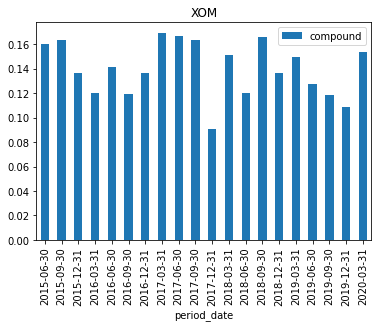

In [28]:
#a sample chart of one ticker.

pd.options.mode.chained_assignment = None
df_plot = df_data[df_data['ticker'] == 'XOM'] #setting w copy warning

df_plot['period_date'] = pd.to_datetime(df_plot['period_date'])
df_plot['period_date'] = df_plot.period_date.map(lambda x: x.strftime('%Y-%m-%d')) #format

df_plot.compound = pd.to_numeric(df_plot.compound)

df_plot.plot.bar(x='period_date', y='compound', rot=90,title='XOM')


In [29]:
#zip your archives for local use... download into your git directory.
#the R code will not pull if it finds these files.
!zip -r Archives.zip Archives

  adding: Archives/ (stored 0%)
  adding: Archives/edgar/ (stored 0%)
  adding: Archives/edgar/data/ (stored 0%)
  adding: Archives/edgar/data/31462/ (stored 0%)
  adding: Archives/edgar/data/31462/000155837018008282/ (stored 0%)
  adding: Archives/edgar/data/31462/000155837018008282/0001558370-18-008282-index.csv (deflated 76%)
  adding: Archives/edgar/data/31462/000155837018008282/ecl-20180930x10q.htm (deflated 88%)
  adding: Archives/edgar/data/31462/000155837018000999/ (stored 0%)
  adding: Archives/edgar/data/31462/000155837018000999/ecl-20171231x10k.htm (deflated 85%)
  adding: Archives/edgar/data/31462/000155837018000999/0001558370-18-000999-index.csv (deflated 80%)
  adding: Archives/edgar/data/31462/000155837019003797/ (stored 0%)
  adding: Archives/edgar/data/31462/000155837019003797/0001558370-19-003797-index.csv (deflated 77%)
  adding: Archives/edgar/data/31462/000155837019003797/ecl-20190331x10q.htm (deflated 87%)
  adding: Archives/edgar/data/31462/000155837018006163/ (s